<a href="https://colab.research.google.com/github/dharshh17/phishing/blob/main/Finalprojectphishing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.cluster import KMeans
import tensorflow as tf
import seaborn as sns

from google.colab import files
data=files.upload()




Saving phishing to phishing


Unique values and their counts in the 'label' column:


,count
label,
1,134850
0,100945


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1843/1843 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Accuracy: 0.999796434205839
Precision: 0.9996451698749224
Recall: 1.0
F1: 0.9998225534557714
ROC-AUC: 0.9999800435446387


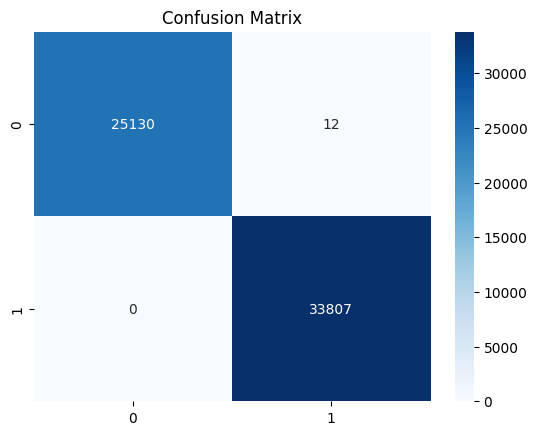

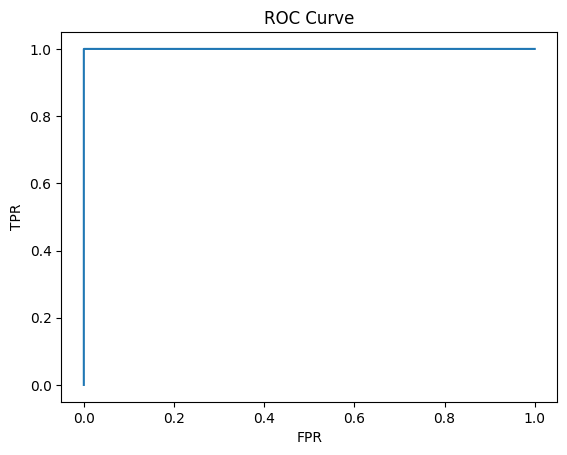

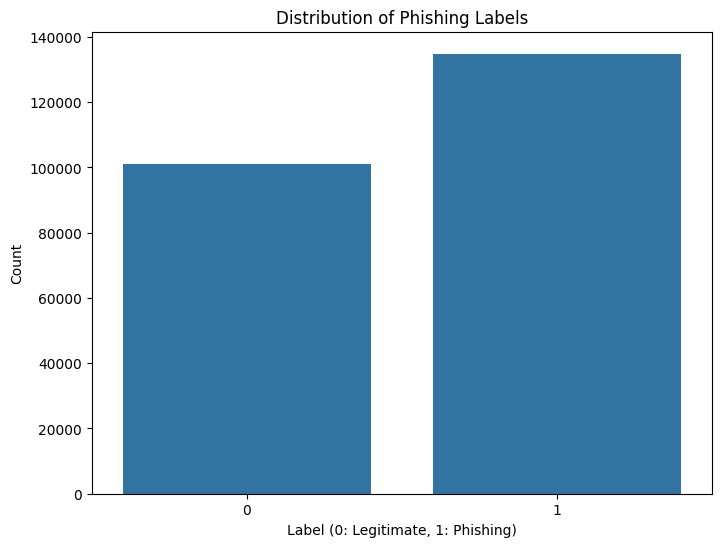

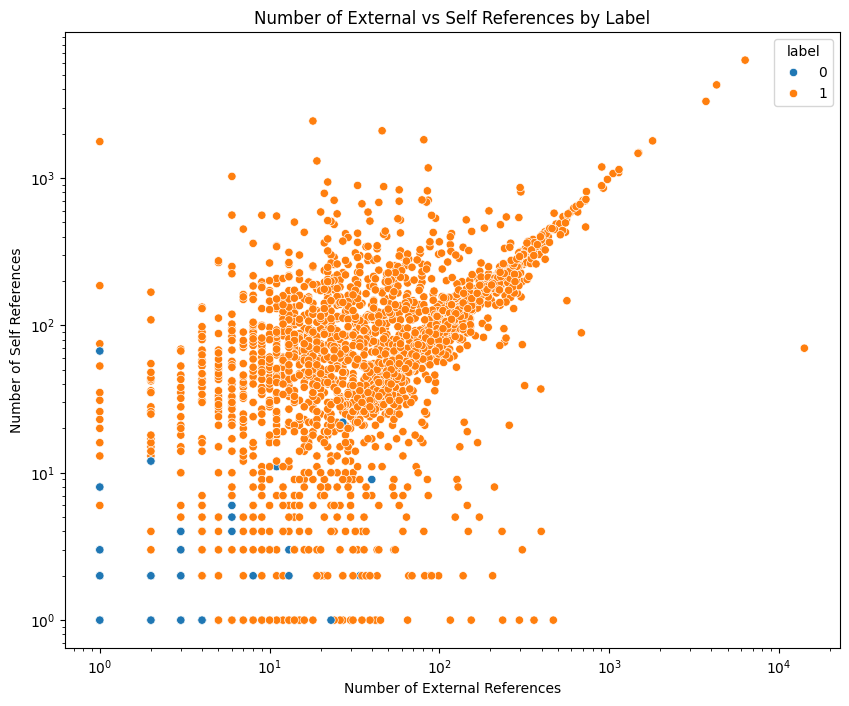

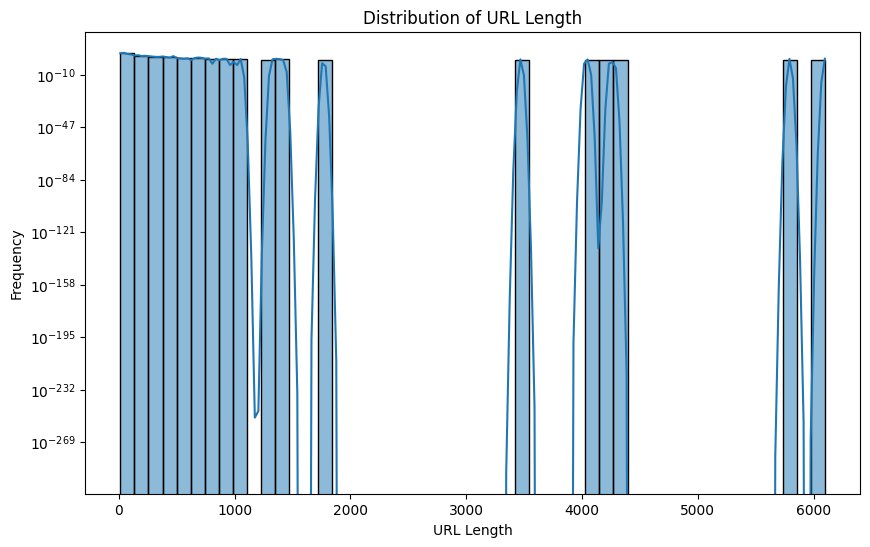

In [2]:
df = pd.read_csv("phishing")
df = df.drop_duplicates()

# Drop 'FILENAME' and 'URL' as they are not features for the model
df = df.drop(['FILENAME', 'URL'], axis=1, errors='ignore')

print("Unique values and their counts in the 'label' column:")
display(df['label'].value_counts())

# Identify feature columns (all columns except 'label')
feature_cols = df.drop("label", axis=1).columns

# Convert all feature columns to numeric, coercing errors to NaN
for col in feature_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Impute missing values for numeric columns with their median
for col in feature_cols:
    if df[col].isnull().any():
        median_val = df[col].median()
        if pd.isna(median_val):
            df[col] = df[col].fillna(0) # Fallback to 0 if median is NaN (e.g., all NaNs)
        else:
            df[col] = df[col].fillna(median_val)

X = df.drop("label", axis=1)
y = df["label"].astype(int) # Ensure label is integer (0 or 1)

# No explicit categorical features identified from phishing.csv that need LabelEncoding beyond numeric conversion

sc = StandardScaler()
X = sc.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

model.save("tf_model.keras")

y_prob = model.predict(X_test).ravel()
y_pred = (y_prob > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.show()

kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto')
df["cluster"] = kmeans.fit_predict(X)


plt.figure(figsize=(8, 6))
sns.countplot(x=df['label'])
plt.title('Distribution of Phishing Labels') # Changed title to be more descriptive
plt.xlabel('Label (0: Legitimate, 1: Phishing)')
plt.ylabel('Count')
plt.show()


plt.figure(figsize=(10, 8))
# Using 'NoOfExternalRef' and 'NoOfInternalRef' as they represent similar concepts to src/dst bytes
sns.scatterplot(x='NoOfExternalRef', y='NoOfSelfRef', hue='label', data=df.sample(n=min(len(df), 5000), random_state=42)) # Sample for better visualization if dataset is large
plt.title('Number of External vs Self References by Label') # Updated title
plt.xlabel('Number of External References') # Updated x-axis label
plt.ylabel('Number of Self References') # Updated y-axis label
plt.xscale('log')
plt.yscale('log')
plt.show()


plt.figure(figsize=(10, 6))
sns.histplot(df['URLLength'], bins=50, kde=True) # Changed from 'duration' to 'URLLength'
plt.title('Distribution of URL Length') # Updated title
plt.xlabel('URL Length')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()